In [1]:
import numpy as np
import glob
import cv2
import blobfile as bf
import PIL
import copy
import matplotlib.pyplot as plt
from pytorch_lightning import seed_everything
seed_everything(47)

def _list_image_files_recursively(data_dir):
    results = []
    for entry in sorted(bf.listdir(data_dir)):
        full_path = bf.join(data_dir, entry)
        ext = entry.split(".")[-1]
        if "." in entry and ext.lower() in ["jpg", "jpeg", "png", "gif"]:
            results.append(full_path)
        elif bf.isdir(full_path):
            results.extend(_list_image_files_recursively(full_path))
    return results

def plot_sample(img, highlight=None, **kwargs):
    columns = 6
    rows = 17
    fig = plt.figure(figsize=(20, 20), dpi=100)
    pt = 0
    for i in range(0, img.shape[0]):
        s_ = img[i]
        
        if highlight is not None:
            top, bottom, left, right = [10]*4

            if i == highlight['base_idx']:
                s_ = cv2.copyMakeBorder(s_, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 255, 0))
            elif i == highlight['src_idx']:
                s_ = cv2.copyMakeBorder(s_, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 255))
            elif i == highlight['dst_idx']:
                s_ = cv2.copyMakeBorder(s_, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(255, 0, 0))
            
        fig.add_subplot(rows, columns, pt+1)
        plt.imshow(s_)
        pt += 1

        if kwargs is not None:
            # Plot other images
            for k in kwargs:
                fig.add_subplot(rows, columns, pt+1)
                s_ = kwargs[k][i].astype(np.uint8)
                plt.imshow(s_)
                pt += 1
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.65, 
                        top=0.9, 
                        wspace=0.1, 
                        hspace=0.2)
    plt.show()
    return fig



Global seed set to 47


In [2]:
def normalize_image(img, convention='CHW'):
    '''
    :params img: the input image
    '''
    if convention == 'CHW':
        agg_axes = (1, 2)
    elif convention == 'HWC':
        agg_axes = (0, 1)
    else: NotImplementedError
    
    img = (img - np.min(img, axis=agg_axes, keepdims=True)) / (np.max(img, axis=agg_axes, keepdims=True) - np.min(img, axis=agg_axes, keepdims=True))
    return img

## SH factors for lighting
pi = np.pi
constant_factor = np.array([1/np.sqrt(4*pi), 
                                ((2*pi)/3)*(np.sqrt(3/(4*pi))), 
                                ((2*pi)/3)*(np.sqrt(3/(4*pi))),
                                ((2*pi)/3)*(np.sqrt(3/(4*pi))), 
                                (pi/4)*(3)*(np.sqrt(5/(12*pi))), 
                                (pi/4)*(3)*(np.sqrt(5/(12*pi))),
                                (pi/4)*(3)*(np.sqrt(5/(12*pi))), 
                                (pi/4)*(3/2)*(np.sqrt(5/(12*pi))), 
                                (pi/4)*(1/2)*(np.sqrt(5/(4*pi)))])

def add_SHlight(normal_images, sh_coeff):
    '''
        sh_coeff: [bz, 9, 3]
    '''
    N = normal_images   # [bz, C, H, W]; c=3
    # Extract the Normal images to put into the SH
    sh = np.stack([
            N[:,0]*0.+1.,   # 1
            N[:,0],         # X
            N[:,1],         # Y
            N[:,2],         # Z
            N[:,0]*N[:,1],  # X*Y
            N[:,0]*N[:,2],  # X*Z
            N[:,1]*N[:,2],  # Y*Z
            N[:,0]**2 - N[:,1]**2,  # X**2 - Y**2
            3*(N[:,2]**2) - 1,      # 3(Z**2) - 1
            ], 
            1) # [bz, 9, h, w]
    
    sh = sh * constant_factor[None,:,None,None]
    shading = np.sum(sh_coeff[:,:,:,None,None] * sh[:,:,None,:,:], axis=1) # [bz, 9, 3, h, w]
    return shading

# How much background affect the lighting estimation from DECA?

In [3]:
# Load images of foreground/background/original

fgr_file = _list_image_files_recursively('./fgr/')
bgr_file = _list_image_files_recursively('./bgr/')
org_file = _list_image_files_recursively('./org/')
print(len(fgr_file), len(bgr_file), len(org_file))


file_dict = {}
for path in org_file:
    name = path.split('/')[-1]
    file_dict[name] = {'org':None, 'fgr':None}
    file_dict[name]['org'] = path
    file_dict[name]['fgr'] = [p for p in fgr_file if name.split('.')[0] in p][0]
    assert file_dict[name]['fgr'] != None
    assert file_dict[name]['org'] != None

# Check all images have paired.
tmp = copy.deepcopy(fgr_file)
for i in list(file_dict.keys()):
    i = i.split('.')[0]
    for idx, j in enumerate(tmp):
        if i in j:
            del(tmp[idx])
assert tmp == []


32 19 32


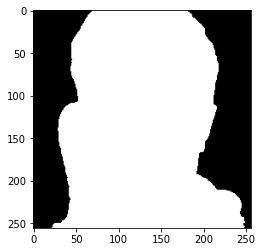

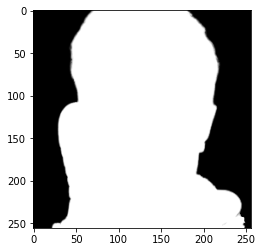

In [4]:
image_dict = copy.deepcopy(file_dict)
for name, v in file_dict.items():
    for k in ['org', 'fgr']:
        with bf.BlobFile(v[k], "rb") as f:
            pil_image = PIL.Image.open(f)
            pil_image.load()
            pil_image = pil_image.convert("RGBA")
        image_dict[name][k] = np.array(pil_image).astype(np.uint8)
    image_dict[name]['mask'] = image_dict[name]['fgr'] != 0
    # image_dict[name]['mask'] = 1 - np.isclose(image_dict[name]['fgr'], [0])
    # image_dict[name]['mask'] = image_dict[name]['mask'][..., [0]] * image_dict[name]['mask'][..., [1]] * image_dict[name]['mask'][..., [2]]

im = image_dict['60065.jpg']
plt.imshow(im['fgr'][..., [3]] > 127.5, cmap='gray')
plt.show()

plt.imshow(im['fgr'][..., [3]], cmap='gray')
plt.show()

bgr_dict = {}
for path in bgr_file:
    name = path.split('/')[-1]
    with bf.BlobFile(path, "rb") as f:
        pil_image = PIL.Image.open(f)
        pil_image.load()
        pil_image = pil_image.convert("RGBA")
    bgr_dict[name] = np.array(pil_image)

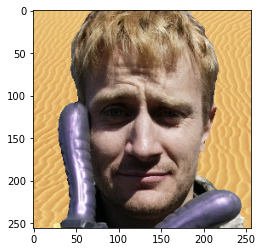

In [5]:
# Overlay the image
def overlay_image(fgr, bgr, mask):
    '''
    Overlay the image
    :param fgr: foreground image
    :param bgr: background image
    :param mask: mask image
    [#] All images need to be the same shape (H, W, 3)
    '''
    return (fgr * mask) + bgr * (1 - mask)

def random_crop(img, image_size=256):
    import random
    crop_y = random.randrange(img.shape[0] - image_size + 1)
    crop_x = random.randrange(img.shape[1] - image_size + 1)
    return img[crop_y : crop_y + image_size, crop_x : crop_x + image_size]

img_name = '60065.jpg'
bgr_name = [name for name in bgr_dict.keys() if 'sahara' in name][0]

ovl_im = overlay_image(fgr=image_dict[img_name]['fgr'][..., [0, 1, 2]], 
                    bgr=random_crop(bgr_dict[bgr_name][..., [0, 1, 2]]),
                    mask=image_dict[img_name]['fgr'][..., [3]] > 127.5)
plt.imshow(ovl_im)
plt.show()


Global seed set to 47


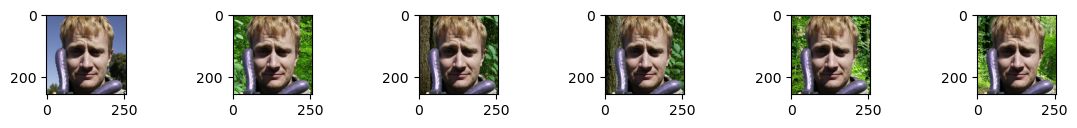

In [6]:
# Create Overlay samples
img_name = '60065.jpg'
bgr_name = [name for name in bgr_dict.keys() if 'forest' in name][0]

ovl_dict = {img_name:{}}
seed_everything(47)
for i in range(5):
    if i == 0:
        ovl_dict[img_name][bgr_name] = [image_dict[img_name]['org'][..., [0, 1, 2]]]
    
    ovl_img = overlay_image(fgr=image_dict[img_name]['fgr'][..., [0, 1, 2]], 
                        bgr=random_crop(bgr_dict[bgr_name][..., [0, 1, 2]]),
                        mask=image_dict[img_name]['fgr'][..., [3]] > 127.5)
    ovl_dict[img_name][bgr_name].append(ovl_img)

fig = plot_sample(img=np.stack(ovl_dict[img_name][bgr_name], axis=0))

In [7]:
# Test on DECA

from skimage.io import imread, imsave
import importlib
x = imread('./bgr/plain/black.png')
import sys
def get_deca(data, dat_type, cfg=None):
    # In-the-wild
    sys.path.append('../../../cond_utils/')
    sys.path.append('../../../cond_utils/deca/')
    from deca import get_deca_emb
    importlib.reload(get_deca_emb)

    itw_path = "../../itw_images/aligned/"
    device = 'cuda:2'

    # DECA
    deca_itw, images = get_deca_emb.get_deca_emb(data=data, dat_type=dat_type, device=device)

    params_itw = {}
    for img_name in deca_itw.keys():
        params_itw[img_name] = deca_itw[img_name]
        
    params_set = params_itw
    return params_set, images


total 7 images
creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/deca/data/deca_model.tar


/home/mint/miniconda3/envs/3dr_conda/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:457: UserWarning: Mtl file does not exist: /home/mint/guided-diffusion/sample_scripts/cond_utils/deca/data/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")
  0%|          | 0/7 [00:00<?, ?it/s]

dict_keys(['shape', 'tex', 'exp', 'pose', 'cam', 'light', 'images', 'detail'])
dict_keys(['verts', 'trans_verts', 'landmarks2d', 'landmarks3d', 'landmarks3d_world', 'light', 'pose', 'exp', 'grid', 'rendered_images', 'alpha_images', 'normal_images', 'uv_texture', 'normals', 'uv_detail_normals', 'displacement_map', 'uv_texture_gt'])
dict_keys(['inputs', 'landmarks2d', 'landmarks3d', 'shape_images', 'shape_detail_images'])


/home/mint/miniconda3/envs/3dr_conda/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/home/mint/miniconda3/envs/3dr_conda/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


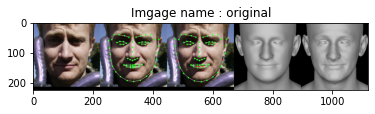

 14%|█▍        | 1/7 [00:06<00:41,  6.88s/it]

dict_keys(['shape', 'tex', 'exp', 'pose', 'cam', 'light', 'images', 'detail'])
dict_keys(['verts', 'trans_verts', 'landmarks2d', 'landmarks3d', 'landmarks3d_world', 'light', 'pose', 'exp', 'grid', 'rendered_images', 'alpha_images', 'normal_images', 'uv_texture', 'normals', 'uv_detail_normals', 'displacement_map', 'uv_texture_gt'])
dict_keys(['inputs', 'landmarks2d', 'landmarks3d', 'shape_images', 'shape_detail_images'])


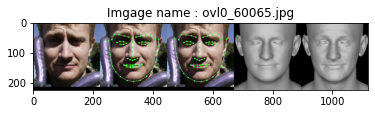

 29%|██▊       | 2/7 [00:07<00:14,  2.97s/it]

dict_keys(['shape', 'tex', 'exp', 'pose', 'cam', 'light', 'images', 'detail'])
dict_keys(['verts', 'trans_verts', 'landmarks2d', 'landmarks3d', 'landmarks3d_world', 'light', 'pose', 'exp', 'grid', 'rendered_images', 'alpha_images', 'normal_images', 'uv_texture', 'normals', 'uv_detail_normals', 'displacement_map', 'uv_texture_gt'])
dict_keys(['inputs', 'landmarks2d', 'landmarks3d', 'shape_images', 'shape_detail_images'])


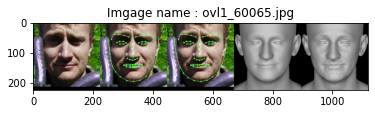

 43%|████▎     | 3/7 [00:07<00:06,  1.71s/it]

dict_keys(['shape', 'tex', 'exp', 'pose', 'cam', 'light', 'images', 'detail'])
dict_keys(['verts', 'trans_verts', 'landmarks2d', 'landmarks3d', 'landmarks3d_world', 'light', 'pose', 'exp', 'grid', 'rendered_images', 'alpha_images', 'normal_images', 'uv_texture', 'normals', 'uv_detail_normals', 'displacement_map', 'uv_texture_gt'])
dict_keys(['inputs', 'landmarks2d', 'landmarks3d', 'shape_images', 'shape_detail_images'])


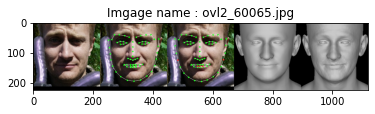

 57%|█████▋    | 4/7 [00:07<00:03,  1.13s/it]

dict_keys(['shape', 'tex', 'exp', 'pose', 'cam', 'light', 'images', 'detail'])
dict_keys(['verts', 'trans_verts', 'landmarks2d', 'landmarks3d', 'landmarks3d_world', 'light', 'pose', 'exp', 'grid', 'rendered_images', 'alpha_images', 'normal_images', 'uv_texture', 'normals', 'uv_detail_normals', 'displacement_map', 'uv_texture_gt'])
dict_keys(['inputs', 'landmarks2d', 'landmarks3d', 'shape_images', 'shape_detail_images'])


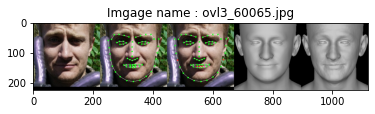

 71%|███████▏  | 5/7 [00:07<00:01,  1.24it/s]

dict_keys(['shape', 'tex', 'exp', 'pose', 'cam', 'light', 'images', 'detail'])
dict_keys(['verts', 'trans_verts', 'landmarks2d', 'landmarks3d', 'landmarks3d_world', 'light', 'pose', 'exp', 'grid', 'rendered_images', 'alpha_images', 'normal_images', 'uv_texture', 'normals', 'uv_detail_normals', 'displacement_map', 'uv_texture_gt'])
dict_keys(['inputs', 'landmarks2d', 'landmarks3d', 'shape_images', 'shape_detail_images'])


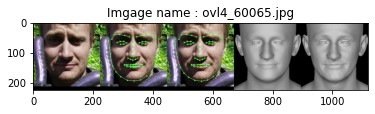

 86%|████████▌ | 6/7 [00:08<00:00,  1.65it/s]

dict_keys(['shape', 'tex', 'exp', 'pose', 'cam', 'light', 'images', 'detail'])
dict_keys(['verts', 'trans_verts', 'landmarks2d', 'landmarks3d', 'landmarks3d_world', 'light', 'pose', 'exp', 'grid', 'rendered_images', 'alpha_images', 'normal_images', 'uv_texture', 'normals', 'uv_detail_normals', 'displacement_map', 'uv_texture_gt'])
dict_keys(['inputs', 'landmarks2d', 'landmarks3d', 'shape_images', 'shape_detail_images'])


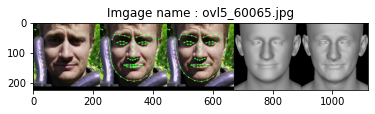

100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


In [8]:
data = {
    'image' : np.concatenate((image_dict[img_name]['org'][..., [0, 1, 2]][None, ...], np.stack((ovl_dict[img_name][bgr_name]), axis=0)), axis=0),
    'imagename' : ['original'] + [f'ovl{i}_{img_name}' for i in range(len(ovl_dict[img_name][bgr_name]))]
    }
params, images = get_deca(data=data, dat_type='img')

In [14]:
print(images.keys())
print(images['original'].keys())
print(images['original']['normal_images'].shape)

dict_keys(['original', 'ovl0_60065.jpg', 'ovl1_60065.jpg', 'ovl2_60065.jpg', 'ovl3_60065.jpg', 'ovl4_60065.jpg', 'ovl5_60065.jpg'])
dict_keys(['rendered_images', 'alpha_images', 'normal_images', 'normals'])
torch.Size([1, 3, 224, 224])


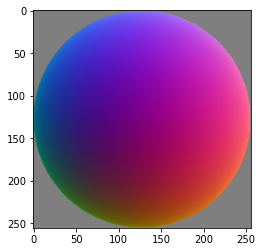

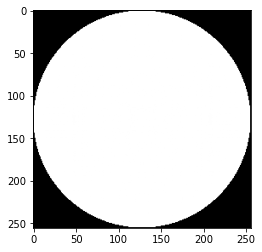

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


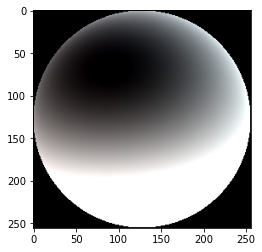

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


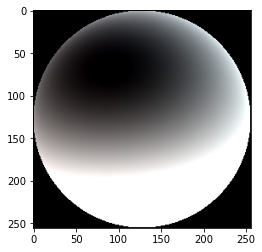

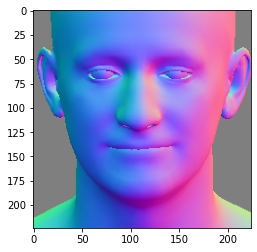

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


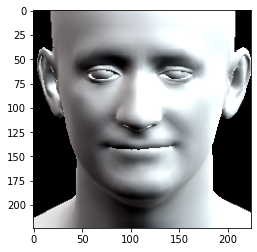

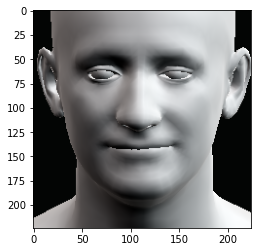

In [19]:
def relit_face(params, images, image_name):
    normal = images[image_name]['normal_images'].detach().cpu().numpy()
    alpha = images[image_name]['alpha_images'].detach().cpu().numpy()
    
    # normal = np.transpose(normal, (2, 0, 1))[None, ...]
    # alpha = np.transpose(alpha, (2, 0, 1))[None, ...]

    light = params[image_name]['light'].reshape(9, 3)[None, ...]
    shading_images = add_SHlight(normal_images=normal, sh_coeff=light)
    shading_images = shading_images * alpha

    plt.imshow(np.transpose(((normal[0] + 1) * 127.5), (1, 2, 0)).astype(np.uint8))
    plt.show()
    plt.imshow(np.transpose((shading_images)[0], (1, 2, 0)))
    plt.show()
    out = normalize_image(shading_images[0], convention='CHW')
    plt.imshow(np.transpose(out, (1, 2, 0)))
    plt.show()
    

def relit_sphere(params, image_name):
    # Create the "Normal map of sphere" using 
    img_size = 256
    x = np.linspace(-1, 1, img_size)
    z = np.linspace(1, -1, img_size)
    x, z = np.meshgrid(x, z)

    mag = np.sqrt(x**2 + z**2)
    valid = mag <=1
    y = -np.sqrt(1 - (x*valid)**2 - (z*valid)**2)
    x = x * valid
    y = y * valid
    z = z * valid
    normal = np.stack((x, y, z), axis=2)    # Forming x, y, z to Normal maps
    plt.imshow((((normal + 1)/2)*255).astype(np.uint8))
    plt.show()
    norm = np.sqrt(np.sum(normal**2, axis=-1))
    plt.imshow(np.stack([norm]*3, axis=-1))
    plt.show()
    
    normal_maps = np.transpose(normal, (2, 0, 1))[None, ...]
    light = params[image_name]['light'].reshape(9, 3)[None, ...]
    shading_images = add_SHlight(normal_images=normal_maps, sh_coeff=light)
    plt.imshow(np.transpose((shading_images * valid)[0], (1, 2, 0)))
    plt.show()

    light = params[image_name]['light'].reshape(9, 3)[None, ...]
    shading_images = add_SHlight(normal_images=normal_maps, sh_coeff=light)
    plt.imshow(np.transpose((shading_images * valid)[0], (1, 2, 0)))
    plt.show()

relit_sphere(params=params, image_name='original')
relit_face(params=params, images=images, image_name='original')


In [ ]:
print(out.keys())
print(out['original'].keys())

dict_keys(['original', 'ovl0_60065.jpg', 'ovl1_60065.jpg', 'ovl2_60065.jpg', 'ovl3_60065.jpg', 'ovl4_60065.jpg', 'ovl5_60065.jpg'])
dict_keys(['shape', 'pose', 'exp', 'cam', 'light'])
